This notebook is a work in progress and mostly a space to experiment with my Spotify data using their API and the Spotipy package, as well as some clustering work.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests

/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.neighbors import NearestNeighbors
from sklearn import cluster, mixture
from sklearn.metrics import consensus_score

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='

In [3]:
import simplejson

In [4]:
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials

In [5]:
#loading credentials
with open("spotifywerk.json") as fh:
    creds = simplejson.loads(fh.read())


In [6]:
cid = creds['client_id']
csecret = creds['secret']
uid = creds['uid']
redirect_uri=creds["redirect_uri"]

In [10]:
#Code reference -- https://towardsdatascience.com/playlist-classification-on-spotify-using-knn-and-naive-bayes-classification-35a279b7e255

client_credentials_manager = SpotifyClientCredentials(client_id=cid, 
                                                      client_secret=csecret) 
scope = 'user-top-read'
try:
    token = util.prompt_for_user_token(uid, scope, 
                                       client_id=cid, 
                                       client_secret=csecret, 
                                       redirect_uri=redirect_uri)  
    sp=spotipy.Spotify(auth= token)
except:
    print('Token is not accesible for ' + uid)

In [11]:
current_playlists = sp.current_user_playlists(limit=50, offset=0)

In [12]:
playlist_list_names = []
playlist_list_ids = []

for i, playlists in enumerate(current_playlists['items']):
    playlist_list_names.append(playlists['name'])
    playlist_list_ids.append(playlists['id'])

In [13]:
playlist_names_ids = dict(zip(playlist_list_names, playlist_list_ids))

In [14]:
list(playlist_names_ids.keys())[0]

'Seatunes'

In [15]:
playlist_tracks = sp.playlist_tracks(playlist_names_ids[list(playlist_names_ids.keys())[0]], fields=None, limit=100, offset=0, market=None)

In [16]:
playlist_tracks['items'][0]

{'added_at': '2021-11-05T06:46:15Z',
 'added_by': {'external_urls': {'spotify': 'https://open.spotify.com/user/jesjes354'},
  'href': 'https://api.spotify.com/v1/users/jesjes354',
  'id': 'jesjes354',
  'type': 'user',
  'uri': 'spotify:user:jesjes354'},
 'is_local': False,
 'primary_color': None,
 'track': {'album': {'album_type': 'single',
   'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/49YbNTLaaAbZHLtDI2aPGL'},
     'href': 'https://api.spotify.com/v1/artists/49YbNTLaaAbZHLtDI2aPGL',
     'id': '49YbNTLaaAbZHLtDI2aPGL',
     'name': 'Tesher',
     'type': 'artist',
     'uri': 'spotify:artist:49YbNTLaaAbZHLtDI2aPGL'},
    {'external_urls': {'spotify': 'https://open.spotify.com/artist/07YZf4WDAMNwqr4jfgOZ8y'},
     'href': 'https://api.spotify.com/v1/artists/07YZf4WDAMNwqr4jfgOZ8y',
     'id': '07YZf4WDAMNwqr4jfgOZ8y',
     'name': 'Jason Derulo',
     'type': 'artist',
     'uri': 'spotify:artist:07YZf4WDAMNwqr4jfgOZ8y'}],
   'available_markets': ['AD',

In [17]:
playlist_tracks['items'][0]['track']['id']

'6FvSS3Goz7OC8oCC2eWqe8'

In [18]:
track_ids = []
for number, track in enumerate(playlist_tracks['items']):
    track_ids.append(track['track']['id'])

In [19]:
track_features = pd.DataFrame.from_dict(sp.audio_features(track_ids))

In [20]:
df = []
for track_id in track_ids:
    track_info = sp.track(track_id)
    
    row = [track_id, 
               track_info['name'], 
               track_info['artists'][0]['name'], 
               track_info['popularity'], 
               track_info['album']['release_date'],
               track_info['explicit']
          ]
    
    df.append(row)
    row = []
    
track_data = pd.DataFrame(df, columns = ['id', 'name', 'artist', 'popularity', 'album_release_dt', 'explicit'])

In [21]:
track_data['id'].nunique()

81

In [22]:
track_data.shape

(81, 6)

In [23]:
playlist_track_data = pd.merge(track_data, track_features, on='id')

In [24]:
playlist_track_data.shape

(81, 23)

In [25]:
playlist_track_data['id'].nunique()

81

In [27]:
playlist_track_data.sample(6)

,id,name,artist,popularity,album_release_dt,explicit,danceability,energy,key,loudness,...,instrumentalness,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature
37,3Be7CLdHZpyzsVijme39cW,What's Love Got to Do with It,Kygo,73,2020-07-17,False,0.750,0.664,8,-5.908,...,0.000000,0.0632,0.617,105.023,audio_features,spotify:track:3Be7CLdHZpyzsVijme39cW,https://api.spotify.com/v1/tracks/3Be7CLdHZpyz...,https://api.spotify.com/v1/audio-analysis/3Be7...,208156,4
71,79wbJeLkXOlJh4AzaWCWfL,How Will I Know,Whitney Houston,74,2021-09-24,False,0.761,0.739,6,-3.591,...,0.000003,0.2300,0.656,118.997,audio_features,spotify:track:79wbJeLkXOlJh4AzaWCWfL,https://api.spotify.com/v1/tracks/79wbJeLkXOlJ...,https://api.spotify.com/v1/audio-analysis/79wb...,213436,4
74,2JSmxLqt8h7ZpJJkfuLJvK,Stunnin' (feat. Harm Franklin),Curtis Waters,66,2020-10-09,True,0.885,0.685,11,-6.429,...,0.000000,0.1480,0.937,99.954,audio_features,spotify:track:2JSmxLqt8h7ZpJJkfuLJvK,https://api.spotify.com/v1/tracks/2JSmxLqt8h7Z...,https://api.spotify.com/v1/audio-analysis/2JSm...,144000,4
34,4NiehSBQthimPzRsVeOgCT,My My My!,Troye Sivan,68,2018-08-31,False,0.701,0.458,1,-7.749,...,0.000151,0.0450,0.482,102.967,audio_features,spotify:track:4NiehSBQthimPzRsVeOgCT,https://api.spotify.com/v1/tracks/4NiehSBQthim...,https://api.spotify.com/v1/audio-analysis/4Nie...,204727,4
60,1OAh8uOEOvTDqkKFsKksCi,Wild Thoughts (feat. Rihanna & Bryson Tiller),DJ Khaled,73,2017-06-22,True,0.671,0.672,0,-3.094,...,0.000000,0.1180,0.632,97.979,audio_features,spotify:track:1OAh8uOEOvTDqkKFsKksCi,https://api.spotify.com/v1/tracks/1OAh8uOEOvTD...,https://api.spotify.com/v1/audio-analysis/1OAh...,204173,4
13,6Im9k8u9iIzKMrmV7BWtlF,34+35,Ariana Grande,84,2020-10-30,True,0.830,0.585,0,-6.476,...,0.000000,0.2480,0.485,109.978,audio_features,spotify:track:6Im9k8u9iIzKMrmV7BWtlF,https://api.spotify.com/v1/tracks/6Im9k8u9iIzK...,https://api.spotify.com/v1/audio-analysis/6Im9...,173711,4


In [28]:
playlist_track_data.columns

Index(['id', 'name', 'artist', 'popularity', 'album_release_dt', 'explicit',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'type', 'uri', 'track_href', 'analysis_url', 'duration_ms',
       'time_signature'],
      dtype='object')

In [29]:
playlist_track_data.describe()

,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.0
mean,67.407407,0.688765,0.696259,5.271605,-5.963049,0.469136,0.074069,0.117220,0.005632,0.181981,0.569774,120.471037,210808.444444,4.0
std,18.723500,0.110701,0.140631,3.885912,1.706209,0.502156,0.066638,0.179408,0.024907,0.145600,0.217052,23.652156,43110.265576,0.0
min,0.000000,0.258000,0.296000,0.000000,-10.965000,0.000000,0.029000,0.000107,0.000000,0.042400,0.096700,89.750000,139810.000000,4.0
25%,57.000000,0.637000,0.623000,1.000000,-7.025000,0.000000,0.038200,0.011900,0.000000,0.090200,0.468000,103.014000,183290.000000,4.0
50%,71.000000,0.701000,0.721000,6.000000,-5.883000,0.000000,0.056500,0.037000,0.000008,0.114000,0.591000,117.016000,208747.000000,4.0
75%,81.000000,0.763000,0.800000,8.000000,-4.771000,1.000000,0.082500,0.145000,0.000095,0.248000,0.712000,123.950000,226198.000000,4.0
max,94.000000,0.885000,0.933000,11.000000,-2.278000,1.000000,0.375000,0.934000,0.169000,0.752000,0.952000,201.800000,453947.000000,4.0


In [30]:
playlist_track_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81 entries, 0 to 80
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                81 non-null     object 
 1   name              81 non-null     object 
 2   artist            81 non-null     object 
 3   popularity        81 non-null     int64  
 4   album_release_dt  81 non-null     object 
 5   explicit          81 non-null     bool   
 6   danceability      81 non-null     float64
 7   energy            81 non-null     float64
 8   key               81 non-null     int64  
 9   loudness          81 non-null     float64
 10  mode              81 non-null     int64  
 11  speechiness       81 non-null     float64
 12  acousticness      81 non-null     float64
 13  instrumentalness  81 non-null     float64
 14  liveness          81 non-null     float64
 15  valence           81 non-null     float64
 16  tempo             81 non-null     float64
 17 

In [31]:
features_to_plot = playlist_track_data.drop(columns=['id', 'name', 'artist','album_release_dt','type', 'explicit','uri', 'track_href', 'analysis_url'],axis=1)

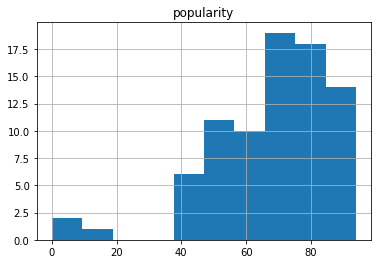

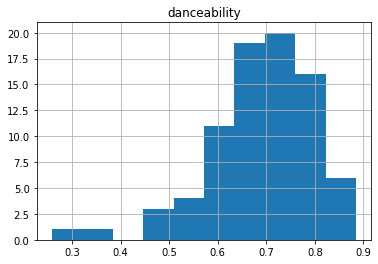

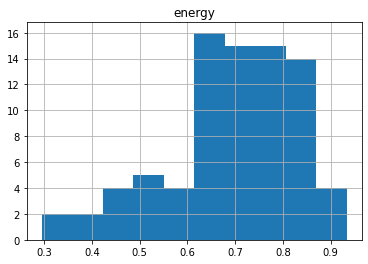

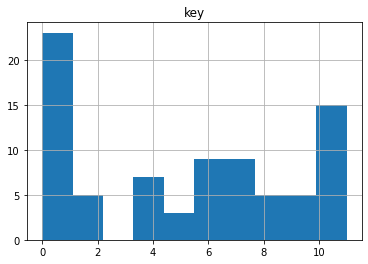

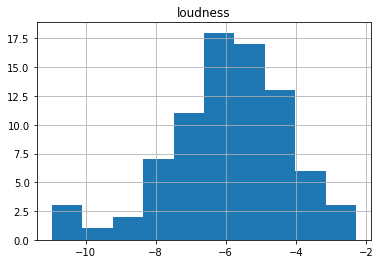

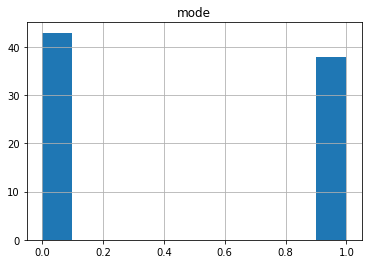

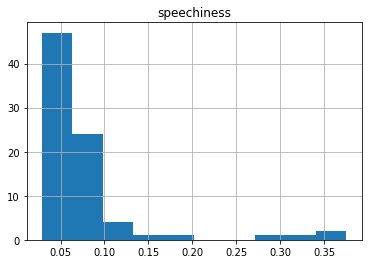

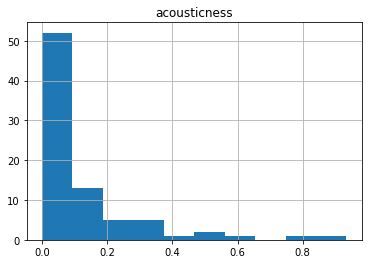

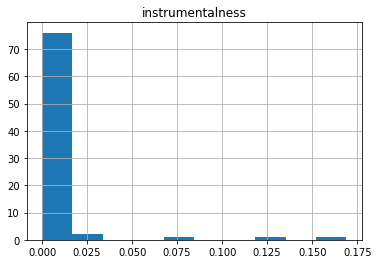

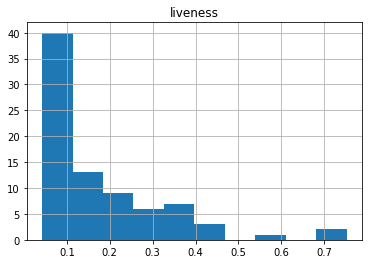

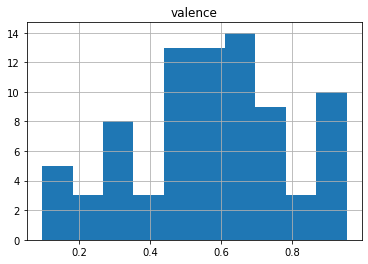

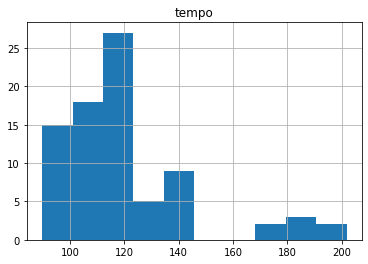

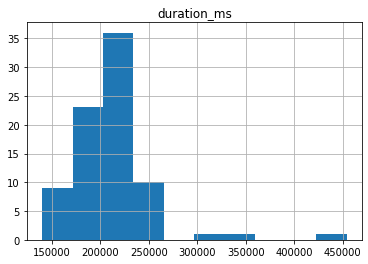

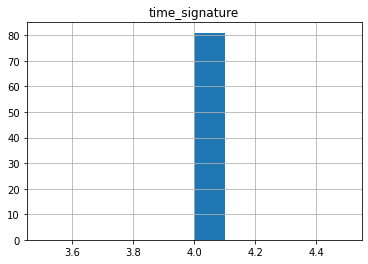

In [32]:
for feature in features_to_plot.columns:
    plt.figure()
    plt.title(feature)
    features_to_plot[feature].hist()

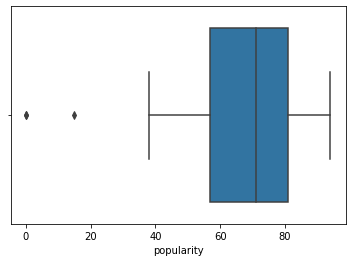

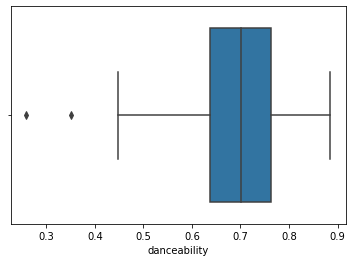

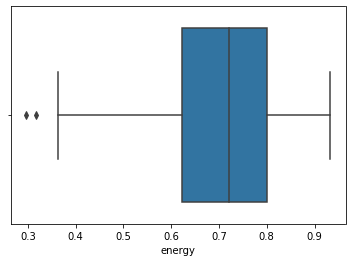

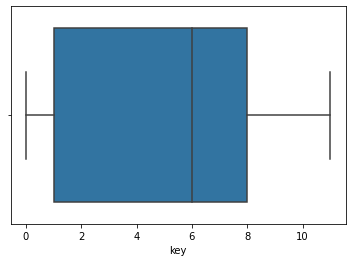

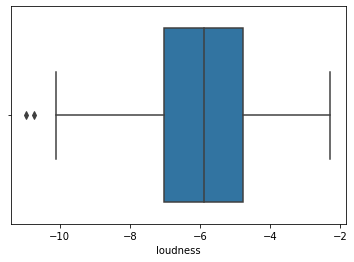

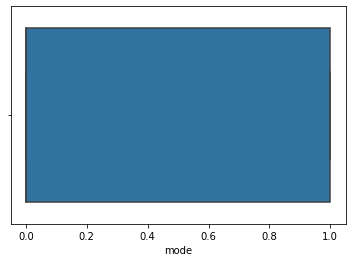

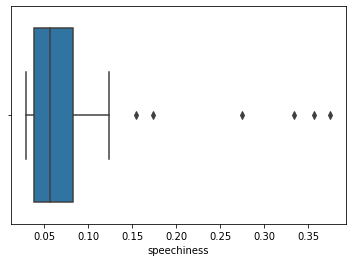

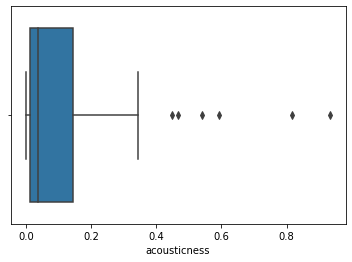

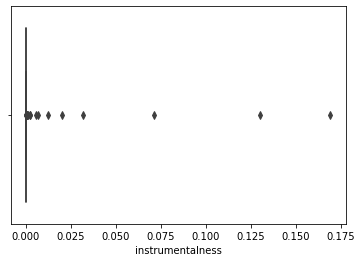

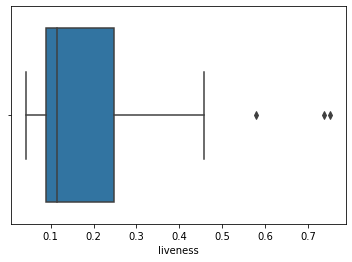

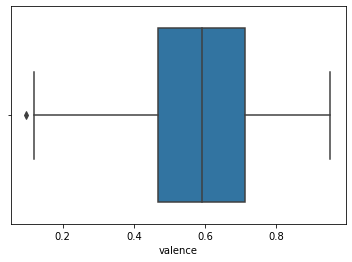

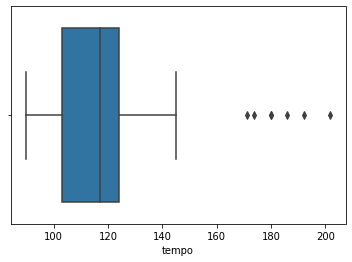

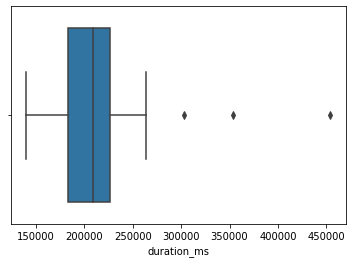

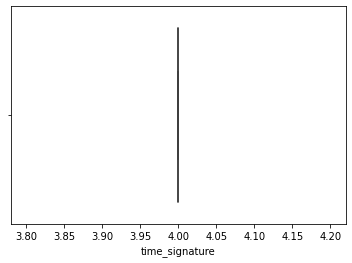

In [33]:
for feature in features_to_plot.columns:
    plt.figure()
    sns.boxplot(feature, data=features_to_plot)

<AxesSubplot:>

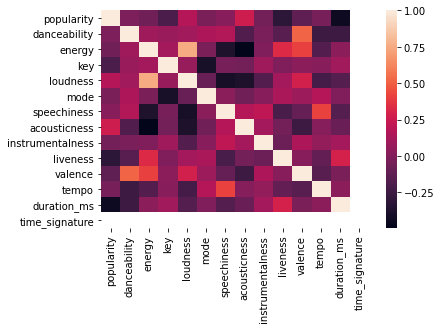

In [34]:
sns.heatmap(features_to_plot.corr())

In [35]:
values = features_to_plot.mean().values.flatten().tolist()
values

[67.4074074074074,
 0.6887654320987656,
 0.696259259259259,
 5.271604938271605,
 -5.963049382716046,
 0.4691358024691358,
 0.07406913580246917,
 0.11722033333333329,
 0.005632337160493829,
 0.18198148148148158,
 0.5697740740740741,
 120.47103703703698,
 210808.44444444444,
 4.0]

In [36]:
categories = list(features_to_plot)
categories

['popularity',
 'danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'duration_ms',
 'time_signature']

In [38]:
spoticluster = features_to_plot[['valence', 'speechiness',
                                'instrumentalness', 
                                'tempo', 'energy', 'key']] 

scaler = preprocessing.MinMaxScaler()

scaled_data = spoticluster
scaled_data[['tempo', 'key']] = scaler.fit_transform(scaled_data[['tempo', 'key']])

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [39]:
spoticluster.describe()

,valence,speechiness,instrumentalness,tempo,energy,key
count,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000
mean,0.569774,0.074069,0.005632,0.274173,0.696259,0.479237
std,0.217052,0.066638,0.024907,0.211086,0.140631,0.353265
min,0.096700,0.029000,0.000000,0.000000,0.296000,0.000000
25%,0.468000,0.038200,0.000000,0.118376,0.623000,0.090909
50%,0.591000,0.056500,0.000008,0.243338,0.721000,0.545455
75%,0.712000,0.082500,0.000095,0.305221,0.800000,0.727273
max,0.952000,0.375000,0.169000,1.000000,0.933000,1.000000


In [40]:
scaled_data.describe()

,valence,speechiness,instrumentalness,tempo,energy,key
count,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000
mean,0.569774,0.074069,0.005632,0.274173,0.696259,0.479237
std,0.217052,0.066638,0.024907,0.211086,0.140631,0.353265
min,0.096700,0.029000,0.000000,0.000000,0.296000,0.000000
25%,0.468000,0.038200,0.000000,0.118376,0.623000,0.090909
50%,0.591000,0.056500,0.000008,0.243338,0.721000,0.545455
75%,0.712000,0.082500,0.000095,0.305221,0.800000,0.727273
max,0.952000,0.375000,0.169000,1.000000,0.933000,1.000000


In [65]:
values

[0.07406913580246917,
 0.005632337160493829,
 0.2741725750739583,
 0.696259259259259,
 0.479236812570146,
 0.07406913580246917]

In [80]:
np.arange(0, 1.25, 0.25)

array([0.  , 0.25, 0.5 , 0.75, 1.  ])

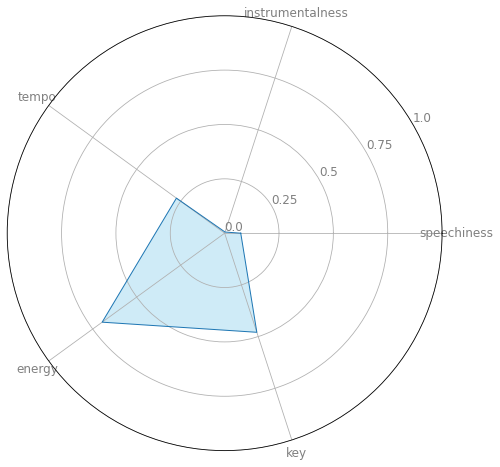

In [81]:
#Code ref -- https://jingwen-z.github.io/data-viz-with-matplotlib-series8-radar-chart/

values = scaled_data.mean().values.flatten().tolist()[1:]
values += values[:1] # repeat the first value to close the circular graph

categories = list(scaled_data)[1:]
angles = [n / float(len(categories)) * 2 * np.pi for n in range(len(categories))]
angles += angles[:1]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8),
                       subplot_kw=dict(polar=True))

plt.xticks(angles[:-1], categories, color='grey', size=12)
plt.yticks(np.arange(0, 1.25, 0.25), ['0.0','0.25', '0.5', '0.75','1.0'],
           color='grey', size=12)
plt.ylim(0, 1)
ax.set_rlabel_position(30)
 
ax.plot(angles, values, linewidth=1, linestyle='solid')
ax.fill(angles, values, 'skyblue', alpha=0.4)

plt.show()

### DBSCAN

In [82]:
# https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc
neighbs = NearestNeighbors(n_neighbors=2)
nbrs = neighbs.fit(scaled_data)

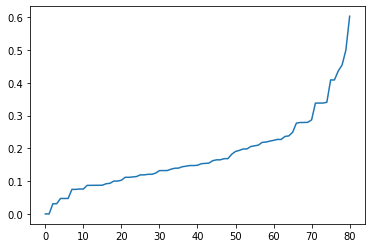

In [83]:
distances, indices = nbrs.kneighbors(scaled_data)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [165]:
db = DBSCAN(eps=0.19, min_samples=3).fit(spoticluster)
labels = db.labels_

playlist_track_data['clusters'] = labels

In [167]:
pd.DataFrame(labels, columns=['labels'])['labels'].value_counts()

-1    31
 0    15
 3    14
 2    12
 4     5
 1     4
Name: labels, dtype: int64

In [168]:
labels

array([-1,  0,  1,  0, -1,  0,  2, -1,  2, -1, -1, -1, -1,  2,  2, -1,  3,
        0,  3,  3,  2, -1,  0, -1,  0,  0,  1, -1,  2, -1, -1, -1,  2,  3,
        2,  3,  3,  3,  0,  3, -1,  3,  0,  4,  4,  2,  3,  2,  0, -1, -1,
       -1, -1,  4,  0,  3, -1, -1,  2, -1,  2, -1, -1,  4,  3, -1, -1, -1,
       -1,  0,  4,  0,  0, -1, -1, -1,  3,  3,  0,  1,  1])

In [169]:
playlist_track_data.query('clusters == 0')

,id,name,artist,popularity,album_release_dt,explicit,danceability,energy,key,loudness,...,uri,track_href,analysis_url,duration_ms,time_signature,clusters,kmeans++,spectral,birch,minibatch
1,4qu63nuBpdn0qHUHuObEj1,Leave Before You Love Me (with Jonas Brothers),Marshmello,87,2021-05-21,False,0.721,0.738,7,-4.770,...,spotify:track:4qu63nuBpdn0qHUHuObEj1,https://api.spotify.com/v1/tracks/4qu63nuBpdn0...,https://api.spotify.com/v1/audio-analysis/4qu6...,154983,4,0,0,0,1,2
3,1SySkCqhEG6Z68o2n07Bsr,In Your Eyes (feat. Kenny G) - Remix,The Weeknd,56,2020-10-16,False,0.606,0.786,7,-3.854,...,spotify:track:1SySkCqhEG6Z68o2n07Bsr,https://api.spotify.com/v1/tracks/1SySkCqhEG6Z...,https://api.spotify.com/v1/audio-analysis/1SyS...,256551,4,0,2,0,1,2
5,6OGogr19zPTM4BALXuMQpF,Take My Breath,The Weeknd,87,2021-08-06,False,0.748,0.740,8,-6.010,...,spotify:track:6OGogr19zPTM4BALXuMQpF,https://api.spotify.com/v1/tracks/6OGogr19zPTM...,https://api.spotify.com/v1/audio-analysis/6OGo...,220196,4,0,0,0,1,2
17,7ef4DlsgrMEH11cDZd32M6,One Kiss (with Dua Lipa),Calvin Harris,81,2018-04-06,False,0.791,0.862,9,-3.240,...,spotify:track:7ef4DlsgrMEH11cDZd32M6,https://api.spotify.com/v1/tracks/7ef4DlsgrMEH...,https://api.spotify.com/v1/audio-analysis/7ef4...,214847,4,0,0,1,1,0
22,5cpJFiNwYyWwFLH0V6B3N8,Del Mar,Ozuna,77,2020-09-04,True,0.759,0.636,6,-5.585,...,spotify:track:5cpJFiNwYyWwFLH0V6B3N8,https://api.spotify.com/v1/tracks/5cpJFiNwYyWw...,https://api.spotify.com/v1/audio-analysis/5cpJ...,214507,4,0,2,0,0,2
24,6uBhi9gBXWjanegOb2Phh0,Stay,Zedd,76,2017-02-23,False,0.690,0.622,5,-5.025,...,spotify:track:6uBhi9gBXWjanegOb2Phh0,https://api.spotify.com/v1/tracks/6uBhi9gBXWja...,https://api.spotify.com/v1/audio-analysis/6uBh...,210091,4,0,2,0,0,2
25,7bhR82JEE9bcX8iphymGme,Box In The Ocean,Alessia Cara,54,2021-09-24,False,0.604,0.592,5,-7.263,...,spotify:track:7bhR82JEE9bcX8iphymGme,https://api.spotify.com/v1/tracks/7bhR82JEE9bc...,https://api.spotify.com/v1/audio-analysis/7bhR...,196697,4,0,2,0,0,2
38,2TeLIzFBe3hxkPR5FIQZut,Like I Can,Sam Smith,86,2014-05-26,False,0.656,0.627,7,-6.627,...,spotify:track:2TeLIzFBe3hxkPR5FIQZut,https://api.spotify.com/v1/tracks/2TeLIzFBe3hx...,https://api.spotify.com/v1/audio-analysis/2TeL...,167066,4,0,2,0,1,2
42,6v3KW9xbzN5yKLt9YKDYA2,Señorita,Shawn Mendes,79,2019-06-19,False,0.759,0.548,9,-6.049,...,spotify:track:6v3KW9xbzN5yKLt9YKDYA2,https://api.spotify.com/v1/tracks/6v3KW9xbzN5y...,https://api.spotify.com/v1/audio-analysis/6v3K...,190800,4,0,0,0,1,0
48,0SaEmR2rdtfsZawPjMYkWg,Put Your Money on Me,Arcade Fire,58,2017-07-28,False,0.604,0.768,7,-6.484,...,spotify:track:0SaEmR2rdtfsZawPjMYkWg,https://api.spotify.com/v1/tracks/0SaEmR2rdtfs...,https://api.spotify.com/v1/audio-analysis/0SaE...,353240,4,0,0,0,1,2


In [170]:
playlist_track_data.query('clusters == 1')

,id,name,artist,popularity,album_release_dt,explicit,danceability,energy,key,loudness,...,uri,track_href,analysis_url,duration_ms,time_signature,clusters,kmeans++,spectral,birch,minibatch
2,7rglLriMNBPAyuJOMGwi39,Cold Heart - PNAU Remix,Elton John,85,2021-10-22,False,0.795,0.800,1,-6.320,...,spotify:track:7rglLriMNBPAyuJOMGwi39,https://api.spotify.com/v1/tracks/7rglLriMNBPA...,https://api.spotify.com/v1/audio-analysis/7rgl...,202735,4,1,1,2,0,1
26,22vgEDb5hykfaTwLuskFGD,Sucker,Jonas Brothers,81,2019-06-07,False,0.842,0.734,1,-5.065,...,spotify:track:22vgEDb5hykfaTwLuskFGD,https://api.spotify.com/v1/tracks/22vgEDb5hykf...,https://api.spotify.com/v1/audio-analysis/22vg...,181027,4,1,1,2,0,1
79,0dj5O3Nc6ONKWNd8mErvND,Rain On Me - Purple Disco Machine Remix - Edit,Lady Gaga,58,2020-07-17,False,0.764,0.772,1,-7.061,...,spotify:track:0dj5O3Nc6ONKWNd8mErvND,https://api.spotify.com/v1/tracks/0dj5O3Nc6ONK...,https://api.spotify.com/v1/audio-analysis/0dj5...,238049,4,1,1,2,0,1
80,6nFCFSL2wOXBM4iHOwpa1y,Money Money,Purple Disco Machine,56,2021-10-15,False,0.741,0.742,0,-5.699,...,spotify:track:6nFCFSL2wOXBM4iHOwpa1y,https://api.spotify.com/v1/tracks/6nFCFSL2wOXB...,https://api.spotify.com/v1/audio-analysis/6nFC...,210211,4,1,1,2,0,1


In [171]:
playlist_track_data.query('clusters == 2')

,id,name,artist,popularity,album_release_dt,explicit,danceability,energy,key,loudness,...,uri,track_href,analysis_url,duration_ms,time_signature,clusters,kmeans++,spectral,birch,minibatch
6,37BZB0z9T8Xu7U3e65qxFy,Save Your Tears (with Ariana Grande) (Remix),The Weeknd,90,2021-04-23,False,0.650,0.825,0,-4.645,...,spotify:track:37BZB0z9T8Xu7U3e65qxFy,https://api.spotify.com/v1/tracks/37BZB0z9T8Xu...,https://api.spotify.com/v1/audio-analysis/37BZ...,191014,4,2,1,3,0,1
8,2ExKb6Ag2WXob6FpkSeXhE,Save Your Tears,The Weeknd,61,2020-04-03,True,0.684,0.817,0,-5.499,...,spotify:track:2ExKb6Ag2WXob6FpkSeXhE,https://api.spotify.com/v1/tracks/2ExKb6Ag2WXo...,https://api.spotify.com/v1/audio-analysis/2ExK...,215627,4,2,1,2,0,1
13,6Im9k8u9iIzKMrmV7BWtlF,34+35,Ariana Grande,84,2020-10-30,True,0.830,0.585,0,-6.476,...,spotify:track:6Im9k8u9iIzKMrmV7BWtlF,https://api.spotify.com/v1/tracks/6Im9k8u9iIzK...,https://api.spotify.com/v1/audio-analysis/6Im9...,173711,4,2,1,3,0,1
14,3e9HZxeyfWwjeyPAMmWSSQ,"thank u, next",Ariana Grande,82,2019-02-08,True,0.717,0.653,1,-5.634,...,spotify:track:3e9HZxeyfWwjeyPAMmWSSQ,https://api.spotify.com/v1/tracks/3e9HZxeyfWwj...,https://api.spotify.com/v1/audio-analysis/3e9H...,207320,4,2,1,3,0,1
20,6oVGIxnuwcwZspPEYk2Yb3,Blow Your Mind (Mwah),Dua Lipa,52,2018-10-19,True,0.654,0.796,2,-4.761,...,spotify:track:6oVGIxnuwcwZspPEYk2Yb3,https://api.spotify.com/v1/tracks/6oVGIxnuwcwZ...,https://api.spotify.com/v1/audio-analysis/6oVG...,178583,4,2,1,3,0,1
28,6UelLqGlWMcVH1E5c4H7lY,Watermelon Sugar,Harry Styles,89,2019-12-13,False,0.548,0.816,0,-4.209,...,spotify:track:6UelLqGlWMcVH1E5c4H7lY,https://api.spotify.com/v1/tracks/6UelLqGlWMcV...,https://api.spotify.com/v1/audio-analysis/6Uel...,174000,4,2,1,3,0,1
32,2cc8Sw1OnCuA5bV8nqWqpE,You,Regard,80,2021-04-16,True,0.691,0.695,0,-5.600,...,spotify:track:2cc8Sw1OnCuA5bV8nqWqpE,https://api.spotify.com/v1/tracks/2cc8Sw1OnCuA...,https://api.spotify.com/v1/audio-analysis/2cc8...,233386,4,2,1,3,0,1
34,4NiehSBQthimPzRsVeOgCT,My My My!,Troye Sivan,68,2018-08-31,False,0.701,0.458,1,-7.749,...,spotify:track:4NiehSBQthimPzRsVeOgCT,https://api.spotify.com/v1/tracks/4NiehSBQthim...,https://api.spotify.com/v1/audio-analysis/4Nie...,204727,4,2,1,3,0,1
45,3I0eHJRr3iUQuZfCk0vBlZ,Lonely (with Jonas Brothers),Diplo,44,2020-05-29,False,0.739,0.717,1,-5.123,...,spotify:track:3I0eHJRr3iUQuZfCk0vBlZ,https://api.spotify.com/v1/tracks/3I0eHJRr3iUQ...,https://api.spotify.com/v1/audio-analysis/3I0e...,139810,4,2,1,3,0,1
47,07Ugv4TA7PvQfoqetnmLrS,Everything Now,Arcade Fire,49,2017-06-01,False,0.548,0.865,0,-5.325,...,spotify:track:07Ugv4TA7PvQfoqetnmLrS,https://api.spotify.com/v1/tracks/07Ugv4TA7PvQ...,https://api.spotify.com/v1/audio-analysis/07Ug...,303013,4,2,1,2,0,1


In [172]:
playlist_track_data.query('clusters == 3')

,id,name,artist,popularity,album_release_dt,explicit,danceability,energy,key,loudness,...,uri,track_href,analysis_url,duration_ms,time_signature,clusters,kmeans++,spectral,birch,minibatch
16,3PfIrDoz19wz7qK7tYeu62,Don't Start Now,Dua Lipa,82,2020-03-27,False,0.793,0.793,11,-4.521,...,spotify:track:3PfIrDoz19wz7qK7tYeu62,https://api.spotify.com/v1/tracks/3PfIrDoz19wz...,https://api.spotify.com/v1/audio-analysis/3PfI...,183290,4,3,0,1,1,0
18,3CDopDW0kwwWil87eE4lhI,Love Again,Dua Lipa,55,2021-10-15,False,0.659,0.667,11,-4.668,...,spotify:track:3CDopDW0kwwWil87eE4lhI,https://api.spotify.com/v1/tracks/3CDopDW0kwwW...,https://api.spotify.com/v1/audio-analysis/3CDo...,258004,4,3,0,1,1,0
19,1AVtceapuF36oZqI9gzp0o,Don't Start Now,Dua Lipa,59,2020-03-27,False,0.793,0.793,11,-4.521,...,spotify:track:1AVtceapuF36oZqI9gzp0o,https://api.spotify.com/v1/tracks/1AVtceapuF36...,https://api.spotify.com/v1/audio-analysis/1AVt...,183290,4,3,0,1,1,0
33,2NjO87HyT80fsgejd3PLYW,Dance To This (feat. Ariana Grande),Troye Sivan,69,2018-08-31,False,0.736,0.756,11,-7.099,...,spotify:track:2NjO87HyT80fsgejd3PLYW,https://api.spotify.com/v1/tracks/2NjO87HyT80f...,https://api.spotify.com/v1/audio-analysis/2NjO...,231847,4,3,0,1,1,0
35,6PQ88X9TkUIAUIZJHW2upE,Bad Habits,Ed Sheeran,94,2021-06-25,False,0.808,0.897,11,-3.712,...,spotify:track:6PQ88X9TkUIAUIZJHW2upE,https://api.spotify.com/v1/tracks/6PQ88X9TkUIA...,https://api.spotify.com/v1/audio-analysis/6PQ8...,231041,4,3,0,1,1,0
36,4vUmTMuQqjdnvlZmAH61Qk,South of the Border (feat. Camila Cabello & Ca...,Ed Sheeran,79,2019-07-12,False,0.857,0.621,9,-6.376,...,spotify:track:4vUmTMuQqjdnvlZmAH61Qk,https://api.spotify.com/v1/tracks/4vUmTMuQqjdn...,https://api.spotify.com/v1/audio-analysis/4vUm...,204467,4,3,0,0,1,0
37,3Be7CLdHZpyzsVijme39cW,What's Love Got to Do with It,Kygo,73,2020-07-17,False,0.750,0.664,8,-5.908,...,spotify:track:3Be7CLdHZpyzsVijme39cW,https://api.spotify.com/v1/tracks/3Be7CLdHZpyz...,https://api.spotify.com/v1/audio-analysis/3Be7...,208156,4,3,0,0,1,0
39,1hJIbOjWpid6LtnozHmzRS,Diamonds,Sam Smith,71,2020-10-30,False,0.637,0.666,10,-6.773,...,spotify:track:1hJIbOjWpid6LtnozHmzRS,https://api.spotify.com/v1/tracks/1hJIbOjWpid6...,https://api.spotify.com/v1/audio-analysis/1hJI...,213869,4,3,0,1,1,0
41,7292H279xDh84LDo5BePPi,Promises (with Sam Smith),Calvin Harris,0,2020-10-30,False,0.781,0.768,11,-5.994,...,spotify:track:7292H279xDh84LDo5BePPi,https://api.spotify.com/v1/tracks/7292H279xDh8...,https://api.spotify.com/v1/audio-analysis/7292...,213309,4,3,0,1,1,0
46,36FaicbcQqoLXBBqTW76Zk,Reflektor,Arcade Fire,0,2015-09-25,False,0.586,0.721,11,-8.277,...,spotify:track:36FaicbcQqoLXBBqTW76Zk,https://api.spotify.com/v1/tracks/36FaicbcQqoL...,https://api.spotify.com/v1/audio-analysis/36Fa...,453947,4,3,0,1,1,0


In [173]:
playlist_track_data.query('clusters == -1')

,id,name,artist,popularity,album_release_dt,explicit,danceability,energy,key,loudness,...,uri,track_href,analysis_url,duration_ms,time_signature,clusters,kmeans++,spectral,birch,minibatch
0,6FvSS3Goz7OC8oCC2eWqe8,Jalebi Baby (Tesher x Jason Derulo),Tesher,77,2021-05-28,True,0.691,0.829,0,-7.179,...,spotify:track:6FvSS3Goz7OC8oCC2eWqe8,https://api.spotify.com/v1/tracks/6FvSS3Goz7OC...,https://api.spotify.com/v1/audio-analysis/6FvS...,169154,4,-1,1,2,0,1
4,4cbdPT6uaBOgOQe3fLMofl,Power is Power (feat. The Weeknd & Travis Scott),SZA,65,2019-04-26,False,0.507,0.644,4,-7.485,...,spotify:track:4cbdPT6uaBOgOQe3fLMofl,https://api.spotify.com/v1/tracks/4cbdPT6uaBOg...,https://api.spotify.com/v1/audio-analysis/4cbd...,211267,4,-1,3,3,0,3
7,0VjIjW4GlUZAMYd2vXMi3b,Blinding Lights,The Weeknd,92,2020-03-20,False,0.514,0.730,1,-5.934,...,spotify:track:0VjIjW4GlUZAMYd2vXMi3b,https://api.spotify.com/v1/tracks/0VjIjW4GlUZA...,https://api.spotify.com/v1/audio-analysis/0VjI...,200040,4,-1,3,3,0,3
9,6huNf4dutXRjJyGn7f5BPS,Pray For Me,The Weeknd,70,2021-02-05,True,0.732,0.678,2,-4.977,...,spotify:track:6huNf4dutXRjJyGn7f5BPS,https://api.spotify.com/v1/tracks/6huNf4dutXRj...,https://api.spotify.com/v1/audio-analysis/6huN...,211421,4,-1,2,3,0,2
10,38JOdzBE9kPj5UhKtqIIqQ,Starboy,The Weeknd,53,2021-02-05,True,0.676,0.588,7,-7.025,...,spotify:track:38JOdzBE9kPj5UhKtqIIqQ,https://api.spotify.com/v1/tracks/38JOdzBE9kPj...,https://api.spotify.com/v1/audio-analysis/38JO...,230461,4,-1,3,3,1,3
11,35mvY5S1H3J2QZyna3TFe0,positions,Ariana Grande,86,2020-10-30,True,0.737,0.802,0,-4.771,...,spotify:track:35mvY5S1H3J2QZyna3TFe0,https://api.spotify.com/v1/tracks/35mvY5S1H3J2...,https://api.spotify.com/v1/audio-analysis/35mv...,172325,4,-1,1,2,0,1
12,6ocbgoVGwYJhOv1GgI9NsF,7 rings,Ariana Grande,85,2019-02-08,True,0.778,0.317,1,-10.732,...,spotify:track:6ocbgoVGwYJhOv1GgI9NsF,https://api.spotify.com/v1/tracks/6ocbgoVGwYJh...,https://api.spotify.com/v1/audio-analysis/6ocb...,178627,4,-1,3,3,0,3
15,39LLxExYz6ewLAcYrzQQyP,Levitating,Dua Lipa,84,2020-03-27,False,0.695,0.884,6,-2.278,...,spotify:track:39LLxExYz6ewLAcYrzQQyP,https://api.spotify.com/v1/tracks/39LLxExYz6ew...,https://api.spotify.com/v1/audio-analysis/39LL...,203808,4,-1,0,0,1,0
21,1j4kHkkpqZRBwE0A4CN4Yv,Dusk Till Dawn - Radio Edit,ZAYN,80,2017-09-07,False,0.258,0.437,11,-6.593,...,spotify:track:1j4kHkkpqZRBwE0A4CN4Yv,https://api.spotify.com/v1/tracks/1j4kHkkpqZRB...,https://api.spotify.com/v1/audio-analysis/1j4k...,239000,4,-1,3,0,1,2
23,6bLopGnirdrilrpdVB6Um1,The Greatest,Sia,67,2016-10-21,False,0.639,0.785,10,-6.167,...,spotify:track:6bLopGnirdrilrpdVB6Um1,https://api.spotify.com/v1/tracks/6bLopGnirdri...,https://api.spotify.com/v1/audio-analysis/6bLo...,210920,4,-1,0,1,1,0


### kmeans ++

In [174]:
#X = scaled_data

In [175]:
#https://towardsdatascience.com/profiling-my-favorite-songs-on-spotify-through-clustering-33fee591783d
X = np.array(scaled_data)
#scaler = StandardScaler()
#scaler.fit()
#X = scaler.transform(X)

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/Applications/anaconda3/lib/python3.7/site-pac

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/Applications/anaconda3/lib/python3.7/site-pac

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/Applications/anaconda3/lib/python3.7/site-pac

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/Applications/anaconda3/lib/python3.7/site-pac

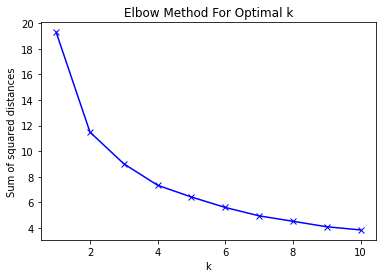

In [176]:
ss_dist = []
K = range(1, 11)
for k in K:
    km = cluster.KMeans(n_clusters=k, init='k-means++')
    km = km.fit(scaled_data)
    ss_dist.append(km.inertia_)
plt.plot(K, ss_dist, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [177]:
nclusters = 4

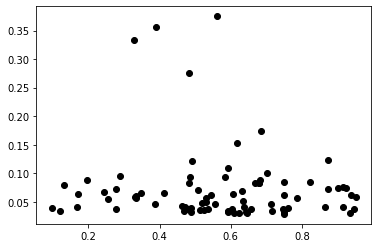

In [178]:
plt.scatter(X[:,0],X[:,1],c='black',label='unclustered data')

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/Applications/anaconda3/lib/python3.7/site-pac

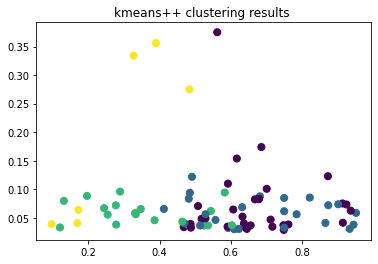

In [179]:
# Fitting K-Means to the dataset
model = cluster.KMeans(n_clusters = nclusters, init = 'k-means++')
model.fit(X)
y_pred = model.labels_
plt.title(f'kmeans++ clustering results ')
plt.scatter(X[:, 0], X[:, 1], s=50, c = y_pred)

In [180]:
scaled_data

,valence,speechiness,instrumentalness,tempo,energy,key
0,0.866,0.0412,0.000000,0.029531,0.829,0.000000
1,0.637,0.0403,0.000004,0.269755,0.738,0.636364
2,0.934,0.0309,0.000073,0.234556,0.800,0.090909
3,0.525,0.0366,0.000095,0.091200,0.786,0.636364
4,0.172,0.0641,0.000000,0.804668,0.644,0.363636
...,...,...,...,...,...,...
76,0.701,0.1010,0.000267,0.163445,0.813,1.000000
77,0.873,0.1230,0.000000,0.251888,0.805,1.000000
78,0.633,0.0523,0.000000,0.269853,0.665,0.818182
79,0.902,0.0739,0.006610,0.296885,0.772,0.090909


In [181]:
playlist_track_data['kmeans++'] = y_pred

### spectral clustering

In [182]:
model = cluster.SpectralClustering(n_clusters = nclusters, eigen_solver='arpack',
        affinity="nearest_neighbors")

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/Applications/anaconda3/lib/python3.7/site-pac

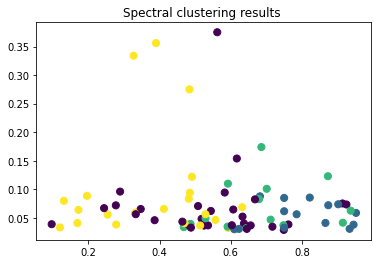

In [183]:
model.fit(X)
y_pred = model.labels_
plt.title(f'Spectral clustering results ')
plt.scatter(X[:, 0], X[:, 1], s=50, c = y_pred)

In [184]:
playlist_track_data['spectral'] = y_pred

### birch clustering

In [185]:
model = cluster.Birch(n_clusters = nclusters)

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/cluster/birch.py:627: ConvergenceWarning: Number of subclusters found (2) by Birch is less than (4). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


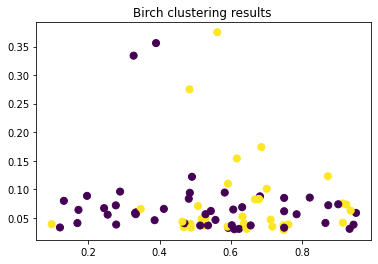

In [186]:
model.fit(X)
y_pred = model.labels_
plt.title(f'Birch clustering results ')
plt.scatter(X[:, 0], X[:, 1], s=50, c = y_pred)

In [187]:
playlist_track_data['birch'] = y_pred

### mini batch kmeans

In [188]:
model = cluster.MiniBatchKMeans(n_clusters=nclusters)

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/Applications/anaconda3/lib/python3.7/site-pac

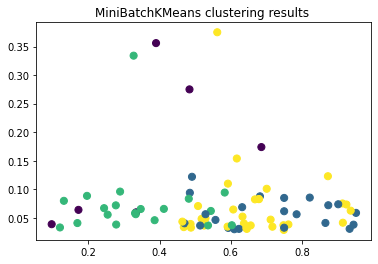

In [189]:
model.fit(X)
y_pred = model.labels_
plt.title(f'MiniBatchKMeans clustering results ')
plt.scatter(X[:, 0], X[:, 1], s=50, c = y_pred)

In [190]:
playlist_track_data['minibatch'] = y_pred

In [191]:
playlist_track_data.sample(5).T

,74,23,3,47,53
id,2JSmxLqt8h7ZpJJkfuLJvK,6bLopGnirdrilrpdVB6Um1,1SySkCqhEG6Z68o2n07Bsr,07Ugv4TA7PvQfoqetnmLrS,5JN0dpZxu1EPljO8AyfcoV
name,Stunnin' (feat. Harm Franklin),The Greatest,In Your Eyes (feat. Kenny G) - Remix,Everything Now,Waves of Blue
artist,Curtis Waters,Sia,The Weeknd,Arcade Fire,Majid Jordan
popularity,66,67,56,49,59
album_release_dt,2020-10-09,2016-10-21,2020-10-16,2017-06-01,2021-10-22
explicit,True,False,False,False,False
danceability,0.885,0.639,0.606,0.548,0.652
energy,0.685,0.785,0.786,0.865,0.861
key,11,10,7,0,6
loudness,-6.429,-6.167,-3.854,-5.325,-4.863
